In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-failure-predictions/machine failure.csv
/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


### Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler


### Data

In [3]:
train_path = "../input/playground-series-s3e17/train.csv"
orig_path = "../input/machine-failure-predictions/machine failure.csv"
test_path = "../input/playground-series-s3e17/test.csv"
sub_path = "../input/playground-series-s3e17/sample_submission.csv"

train_data = pd.read_csv(train_path,index_col="id")
orig_data = pd.read_csv(orig_path,index_col="UDI")
test_data = pd.read_csv(test_path,index_col="id")
sub_df = pd.read_csv(sub_path)

train_data = train_data.append(orig_data)
train_data = train_data.reset_index()


target_col = 'Machine failure'
num_cols = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
binary_cols = ['TWF','HDF','PWF','OSF','RNF']

/tmp/ipykernel_20/2902876089.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(orig_data)


### Helpers

##### Confusion Matrix

In [4]:
# taken from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

##### Submission

In [5]:
def submit_file(model, X_test, filename = 'submission.csv'):
    preds = model.predict_proba(X_test)
    predicted_prob = [pred[1] for pred in preds]
    sub_df['Machine failure'] = predicted_prob
    sub_df.to_csv(filename, index = False)

##### Score

In [6]:
def train_classifier(clf,x_train,y_train,x_test,y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    score = roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
    cf = confusion_matrix(y_pred, y_test)
    make_confusion_matrix(cf)
    print(score)
    return clf

##### Correlation Matrix

In [7]:
def corr_matrix(data):
    plt.figure(figsize = (16,5))
    sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)

### Data Analysis

In [8]:
train_data.head()

index Product ID Type  Air temperature [K]  Process temperature [K]  \
0      0     L50096    L                300.6                    309.6   
1      1     M20343    M                302.6                    312.1   
2      2     L49454    L                299.3                    308.5   
3      3     L53355    L                301.0                    310.9   
4      4     M24050    M                298.0                    309.0   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1596         36.1              140                0    0   
1                    1759         29.1              200                0    0   
2                    1805         26.5               25                0    0   
3                    1524         44.3              197                0    0   
4                    1641         35.4               34                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [9]:
train_data['Fail'] = train_data['TWF'] + train_data['HDF'] + train_data['PWF'] + train_data['OSF'] + train_data['RNF']
test_data['Fail'] = test_data['TWF'] + test_data['HDF'] + test_data['PWF'] + test_data['OSF'] + test_data['RNF']

In [10]:
corr_matrix(train_data)

/tmp/ipykernel_20/3888174110.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)


In [11]:
train_data['Tdiff'] = train_data['Air temperature [K]'] - train_data['Process temperature [K]']
test_data['Tdiff'] = test_data['Air temperature [K]'] - test_data['Process temperature [K]']

In [12]:
corr_matrix(train_data)

/tmp/ipykernel_20/3888174110.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)


- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

- HDF : Heat Dissipation Failure
- PWF : Power failure
- OSF : Overstrain Failure
- TWF : Tool Wear Failure
- RNF : Random Failure

##### Plots

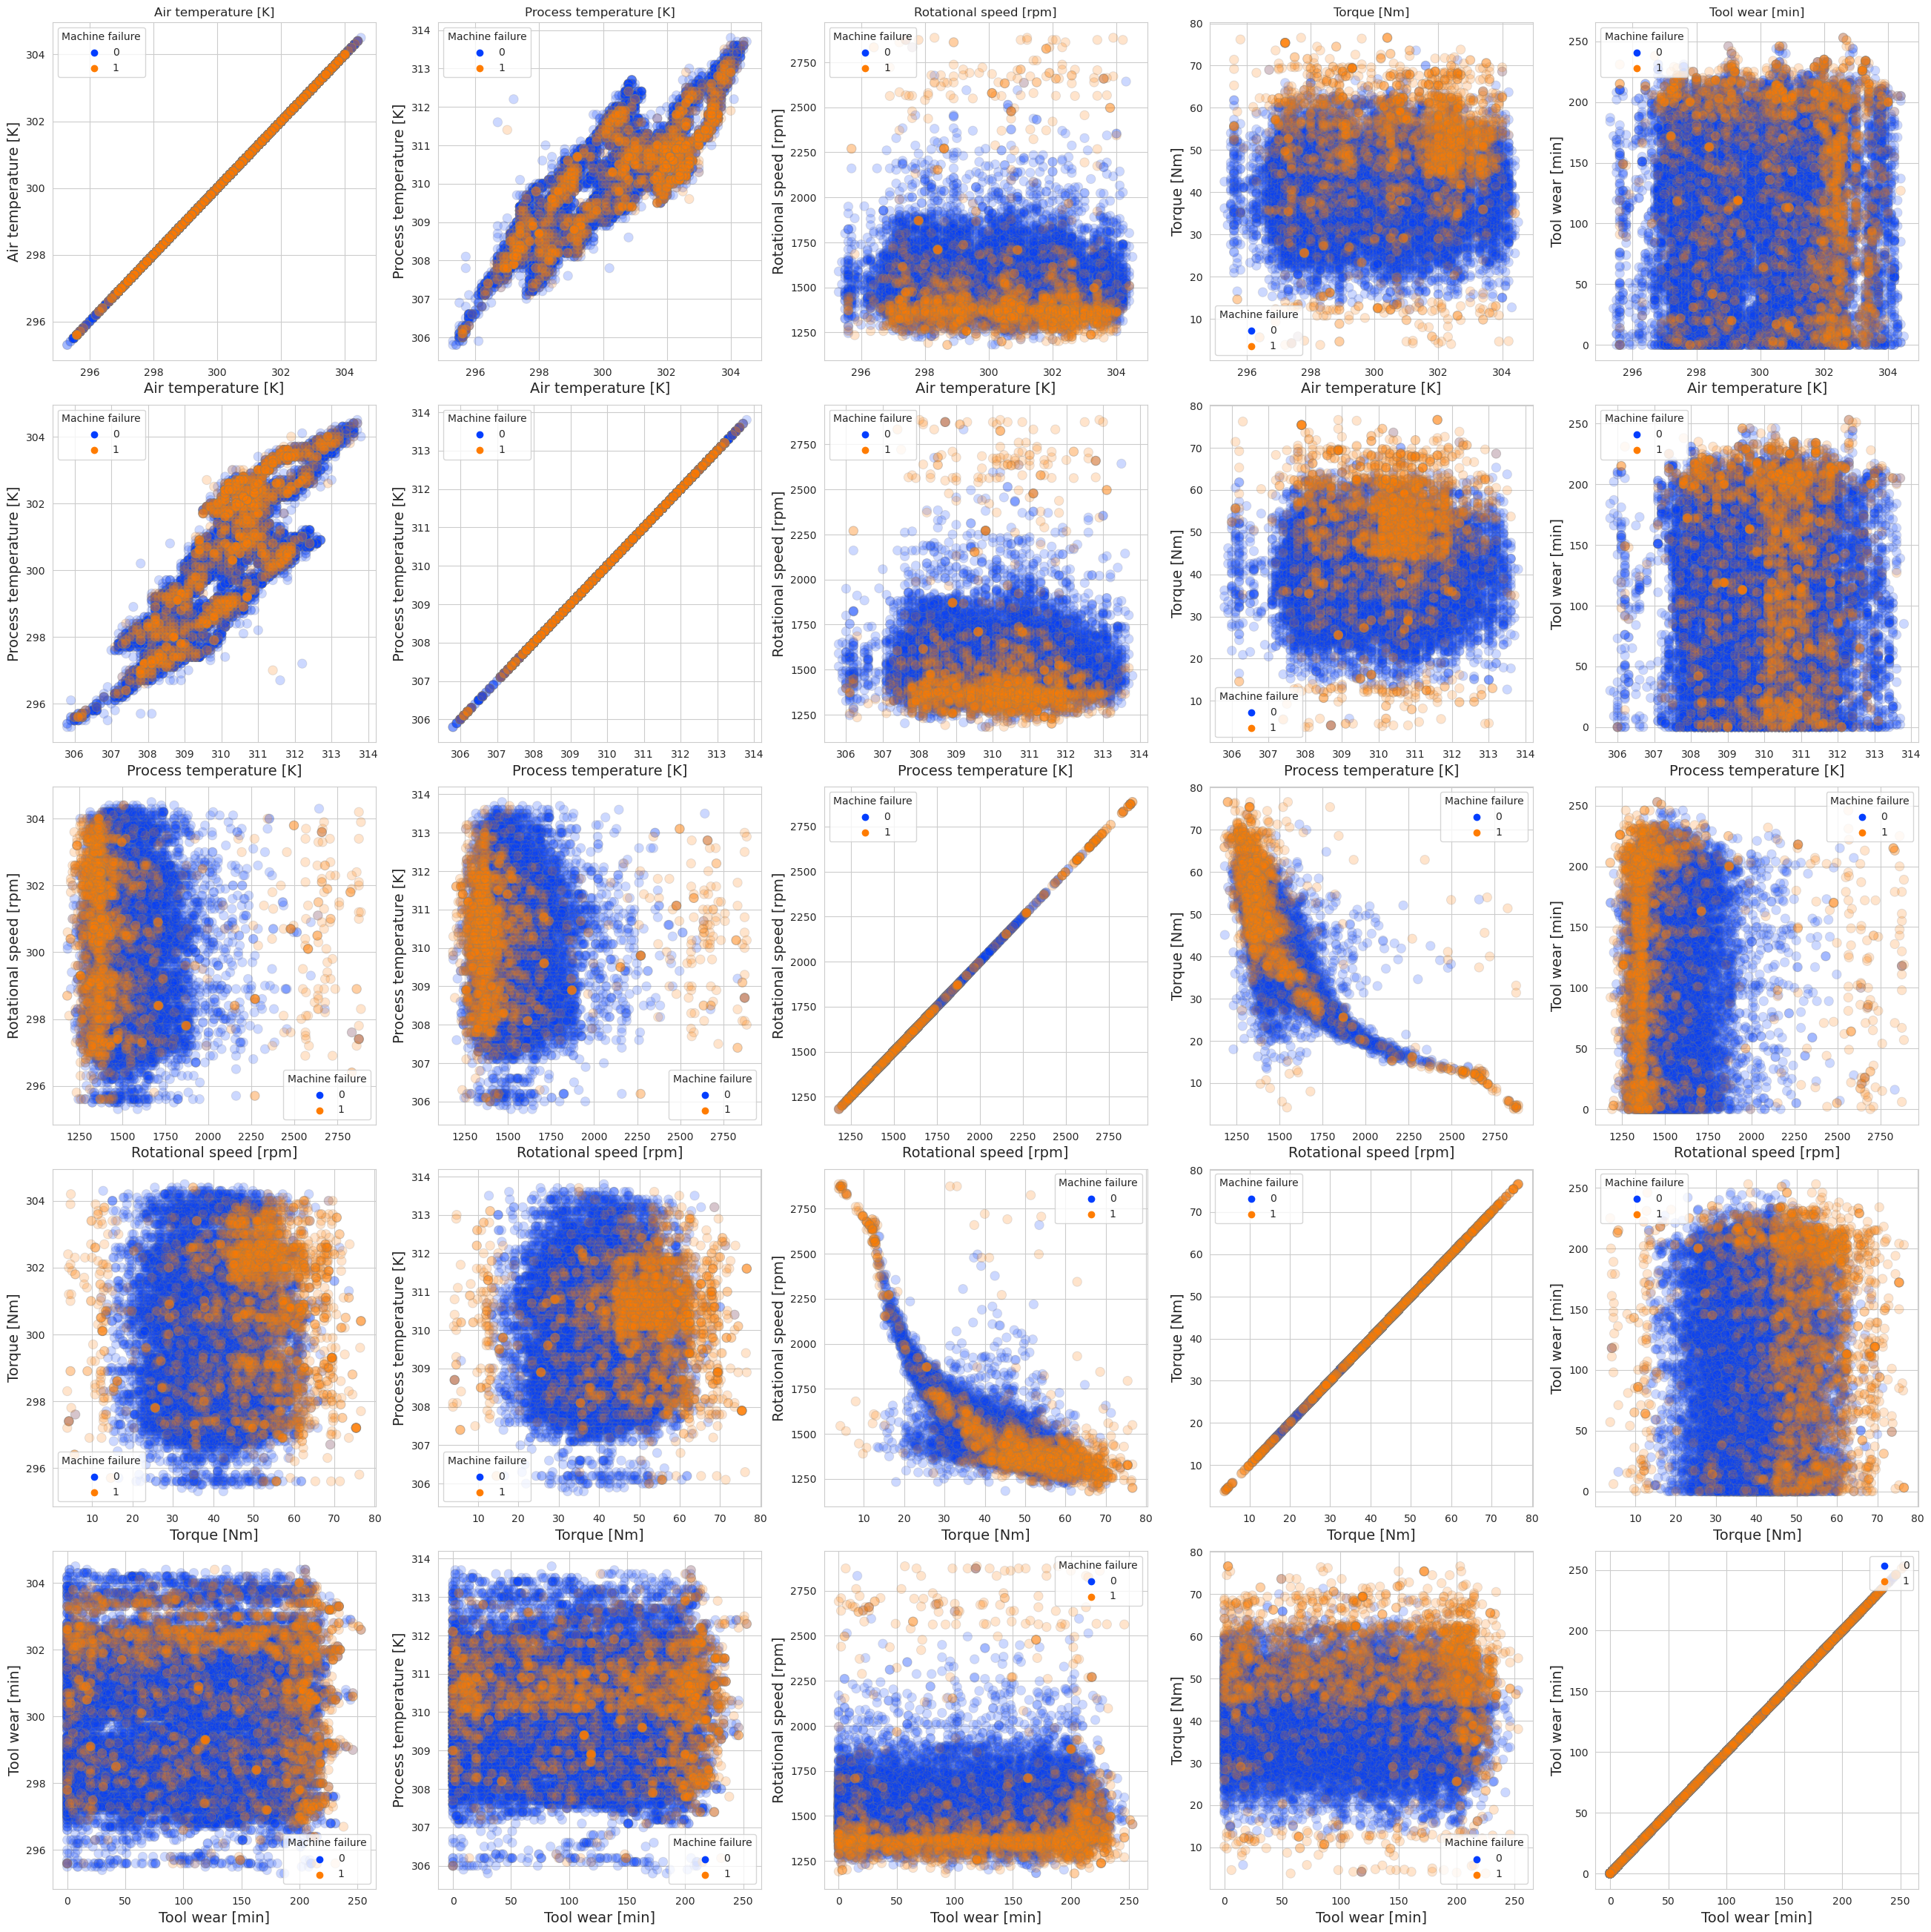

In [13]:
def plot_scatter_matrix(df, target_col, drop_cols=[], size=26):
    # sns.pairplot()
    
    sns.set_style('whitegrid')
    cols = df.columns.drop([target_col] + drop_cols)
    fig, axes = plt.subplots(len(cols), len(cols), figsize=(size, size), sharex=False, sharey=False)

    for i, col in enumerate(cols):
        for j, col_ in enumerate(cols):
            axes[i,j].set_xlabel(f'{col}', fontsize=14)
            axes[i,j].set_ylabel(f'{col_}', fontsize=14)

            # Plot the scatterplot
            sns.scatterplot(data=df, x=col, y=col_, hue=target_col, ax=axes[i,j],
                            s=80, edgecolor='gray', alpha=0.2, palette='bright')

            axes[i,j].tick_params(axis='both', which='major')

            if i == 0:
                axes[i,j].set_title(f'{col_}')
            if j == 0:
                axes[i,j].set_ylabel(f'{col}')

    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    plt.legend(loc='upper right')
    plt.show()
    
sampling_strategy = 0.1
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_res, y_train_res = rus.fit_resample(train_data.drop(target_col, axis=1), train_data[target_col])
plot_scatter_matrix(pd.concat([X_train_res[num_cols], y_train_res], axis=1), target_col)

# del X_train_res, y_train_res, rus

### Encodeing and Scaling

In [14]:
le = LabelEncoder()
le.fit(train_data['Type'])
train_data['Type'] = le.transform(train_data['Type'])
test_data['Type'] = le.transform(test_data['Type'])

# ohe = OneHotEncoder()
# list_one_hot = ['Type']

# for i in list_one_hot:
#     ohe.fit(train_data[i].values.reshape(-1,1))
#     ohe_df = ohe.transform(test_data[i].values.reshape(-1,1)).toarray()
#     dfOneHot = pd.DataFrame(ohe_df, columns = [i+'_'+str(int(j)) for j in range(ohe_df.shape[1])]) 
#     dfOneHot.drop(dfOneHot.columns[[len(dfOneHot.columns)-1]], inplace = True , axis = 1)
#     test_data = pd.concat([test_data, dfOneHot], axis=1)
#     test_data.drop([i], inplace = True , axis = 1)
    
    
    
# for i in list_one_hot:
#     ohe_df = ohe.fit_transform(train_data[i].values.reshape(-1,1)).toarray()
#     dfOneHot = pd.DataFrame(ohe_df, columns = [i+'_'+str(int(j)) for j in range(ohe_df.shape[1])]) 
#     dfOneHot.drop(dfOneHot.columns[[len(dfOneHot.columns)-1]], inplace = True , axis = 1)
#     train_data = pd.concat([train_data, dfOneHot], axis=1)
#     train_data.drop([i], inplace = True , axis = 1)

In [15]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

train_data['Air temperature [K]'] /= 273.15
test_data['Air temperature [K]'] /= 273.15
train_data['Process temperature [K]'] /= 273.15
test_data['Process temperature [K]'] /= 273.15

scaler = MaxAbsScaler()

scaler.fit(train_data[['Rotational speed [rpm]']])
train_data[['Rotational speed [rpm]']] = scaler.transform(train_data[['Rotational speed [rpm]']])
test_data[['Rotational speed [rpm]']] = scaler.transform(test_data[['Rotational speed [rpm]']])

scaler.fit(train_data[['Torque [Nm]']])
train_data[['Torque [Nm]']] = scaler.transform(train_data[['Torque [Nm]']])
test_data[['Torque [Nm]']] = scaler.transform(test_data[['Torque [Nm]']])

scaler.fit(train_data[['Tool wear [min]']])
train_data[['Tool wear [min]']] = scaler.transform(train_data[['Tool wear [min]']])
test_data[['Tool wear [min]']] = scaler.transform(test_data[['Tool wear [min]']])

### Training and Testing

In [16]:
X = train_data[['Type', 'Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Fail']]
Y = train_data['Machine failure']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2)

In [17]:
# clf = AdaBoostClassifier(n_estimators=50, random_state=42)
clf = RandomForestClassifier(n_estimators = 100,random_state = 42)
clf.fit(X_train, y_train).score(X_val, y_val)

0.9946390766919347

0.958044226749472


RandomForestClassifier(random_state=42)

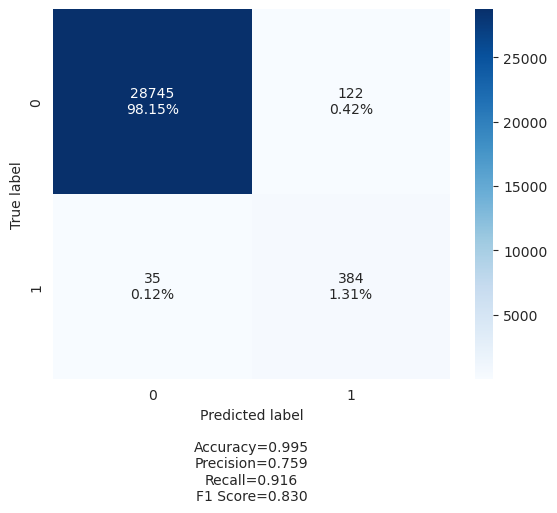

In [18]:
train_classifier(clf, X_train, y_train, X_val, y_val)

In [19]:
submit_file(clf, test_data[['Type', 'Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Fail']])